<IPython.core.display.Javascript object>


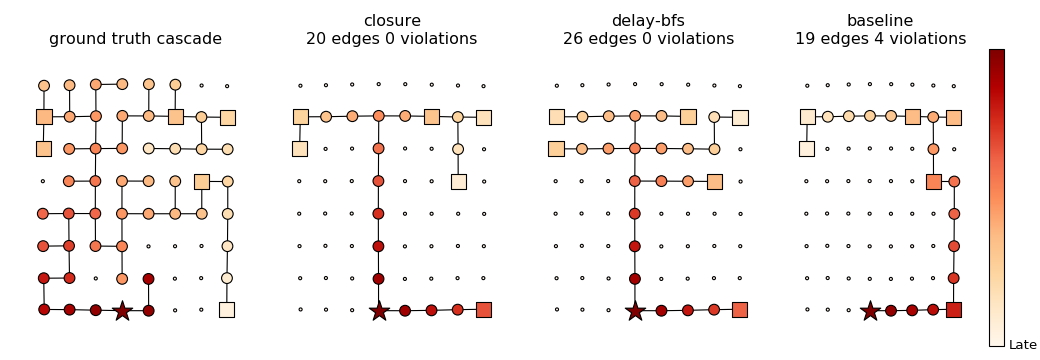

In [16]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView, pbfs_search, BFSVisitor, Graph, min_spanning_tree
from networkx.drawing.nx_agraph import graphviz_layout

from cascade import gen_nontrivial_cascade
from utils import get_rank_index

# seed = 123456
# random.seed(seed)
# np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.10

pos = graphviz_layout(gnx, root=0)


from utils import earliest_obs_node
from tqdm import tqdm
from feasibility import is_order_respected, is_feasible
from steiner_tree_mst import steiner_tree_mst

while True:

    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='ic', return_tree=True,
                                                                           source_includable=True)

    if source not in obs_nodes:
        obs_nodes = list(obs_nodes) + [source]
    root = source

    closure_tree = steiner_tree_mst(
        g, root, infection_times, source, obs_nodes,
        strictly_smaller=False,
        debug=False,
        verbose=False,
        return_closure=False
    )

    from temporal_bfs import temporal_bfs

    tbfs_tree = temporal_bfs(
        g, root, infection_times, source, obs_nodes,
    )

    from ic import MAXINT, get_infection_time
    def infer_infection_time_from_tree(t, source):
        t = GraphView(t)
        b = t.new_vertex_property('bool')
        b.a = True
        t.set_vertex_filter(b)
        times = get_infection_time(t, source=source)
        return times

    def extract_nodes(tree):
        return set(map(int, tree.vertices()))

    from steiner_tree import get_steiner_tree
    from utils import to_directed
    st_tree = get_steiner_tree(
                g, obs_nodes,
                debug=False,
                verbose=False,
            )



    st_tree_dir = to_directed(g, st_tree, root)

    import numpy as np
    from graph_tool import GraphView
    from graph_tool.all import pbfs_search, label_components
    from steiner_tree_mst import extract_edges_from_pred, init_visitor


    def num_order_violations(tree, root, obs_nodes, infection_times):
        tree = GraphView(tree)
        obs_set = set(obs_nodes)
        vfilt = tree.new_vertex_property('bool')
        vfilt.a = True
        tree.set_vertex_filter(vfilt)

        leaves = [o for o in obs_nodes if tree.vertex(o).out_degree() == 0]
        vis = init_visitor(tree, root)
        pbfs_search(tree, root, terminals=leaves, visitor=vis, count_threshold=-1)
        num_vio = 0
        for l in leaves:
            edges = extract_edges_from_pred(tree, root, l, vis.pred)
            edges = edges[::-1]
            path = list(edges[0]) + [u for _, u in edges[1:]]
            useful_nodes_on_path = [v for v in path if v in obs_set]

            for i in range(len(useful_nodes_on_path)-1):
                u, v = useful_nodes_on_path[i: i+2]
                if infection_times[u] > infection_times[v]:
                    num_vio += 1
        return num_vio

    def set_title(ax, name, tree):
        n_vio = num_order_violations(tree, root, obs_nodes, infection_times)
        title = "{}\n{} edges {} violations".format(name, tree.num_edges(), n_vio)
        ax.set_title(title)


    if (num_order_violations(st_tree_dir, root, obs_nodes, infection_times) < 4 or 
        st_tree_dir.num_edges() >= closure_tree.num_edges() or 
        tbfs_tree.num_edges() <=  closure_tree.num_edges()):
        continue
    else:        
        from plot_utils import plot_snapshot, add_colorbar
        from utils import extract_edges

        with_label = False
        max_node_size = 750
        fig, ax = plt.subplots(1, 4, figsize=(13, 4.5))
        for a in ax:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
            a.axis('off')
        plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
                      max_node_size=max_node_size,
                      ax=ax[0],
                      edges=extract_edges(true_tree))
        ax[0].set_title('ground truth cascade')
        plot_snapshot(gnx, pos, infer_infection_time_from_tree(closure_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
                     ax=ax[1], arrows=True, 
                      max_node_size=max_node_size,
                     edges=extract_edges(closure_tree))
        set_title(ax[1], 'closure', closure_tree)

        plot_snapshot(gnx, pos, infer_infection_time_from_tree(tbfs_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
                      ax=ax[2], arrows=True,
                      max_node_size=max_node_size,
                      edges=extract_edges(tbfs_tree))
        set_title(ax[2], 'delay-bfs', tbfs_tree)

        plot_snapshot(gnx, pos, infer_infection_time_from_tree(st_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
                      ax=ax[3], arrows=True,
                      max_node_size=max_node_size,
                      edges=extract_edges(st_tree_dir))
        plt.tight_layout()
        set_title(ax[3], 'baseline', st_tree_dir)

        import matplotlib as mpl
        tick_locator = mpl.ticker.MaxNLocator(nbins=2)
        
        
        cmap='OrRd'
        eps = np.maximum(0.0000000001, np.min(infection_times)/1000.)
        vmin = np.min(infection_times) - eps
        vmax = np.max(infection_times)
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        scm = mpl.cm.ScalarMappable(norm, cmap)
        scm.set_array(infection_times)
        cbar = plt.colorbar(scm)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.set_yticklabels(['Late','Early'])
        break


In [88]:
def get_figure_axes():
    fig = plt.figure(figsize=(s, s-0.5))
    ax = fig.add_subplot(111)    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    return fig, ax
    

<IPython.core.display.Javascript object>


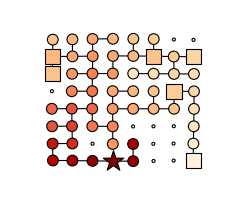

figs/paper_experiment/illustration/ground-truth-viol-0-edges-52.pdf


<IPython.core.display.Javascript object>


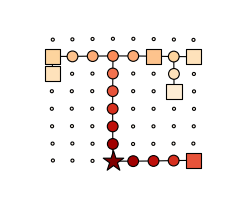

figs/paper_experiment/illustration/closure-viol-0-edges-20.pdf


<IPython.core.display.Javascript object>


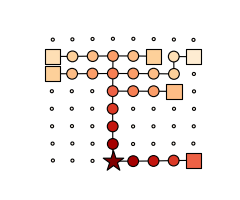

figs/paper_experiment/illustration/delay-bfs-viol-0-edges-26.pdf


<IPython.core.display.Javascript object>


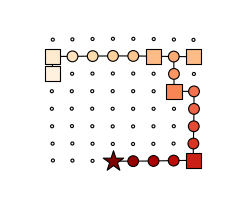

figs/paper_experiment/illustration/baseline-viol-4-edges-19.pdf


In [89]:
from plot_utils import plot_snapshot, add_colorbar
from utils import extract_edges

dirname = 'figs/paper_experiment/illustration/'
with_label = False
max_node_size = 750
s = 3

trees = [true_tree, closure_tree, tbfs_tree, st_tree_dir]
names = ['ground-truth', 'closure', 'delay-bfs', 'baseline']
for name, tree in zip(names, trees):
    fig, ax = get_figure_axes()
    plot_snapshot(gnx, pos, infer_infection_time_from_tree(tree, root),
                  queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
                  max_node_size=max_node_size,
                  ax=ax,
                  edges=extract_edges(tree))
    if path != "ground-truth":
        n_vio = num_order_violations(tree, root, obs_nodes, infection_times)
        size = tree.num_edges()
        path = dirname + '{}-viol-{}-edges-{}.pdf'.format(name, n_vio, size)
    else:
        path = dirname + '{}.pdf'.format(name)
        
    print(path)
    fig.savefig(path)




<IPython.core.display.Javascript object>


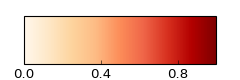

In [66]:
import numpy as np

orientation = 'horizontal'

a = np.array([[0,1]])
if orientation == 'horizontal':
    fig = plt.figure(figsize=(3, 1))
else:
    fig = plt.figure(figsize=(1, 3))
img = plt.imshow(a, cmap="OrRd")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation=orientation, cax=cax)

tick_locator = mpl.ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator

if orientation == 'horizontal':
    cbar.ax.set_xticklabels(['late', '','early'])
else:
    cbar.ax.set_yticklabels(['late', '','early'])

cbar.update_ticks()
    
# fig.tight_layout()
# plt.savefig("colorbar.pdf")

<IPython.core.display.Javascript object>


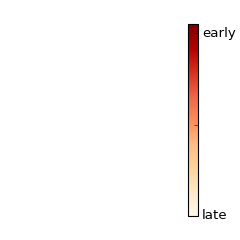

In [75]:
import matplotlib as mpl

orientation = 'vertical'

fig = plt.figure(figsize=(3, 3))
fig.clf()
plt.gca().set_visible(False)
cmap='OrRd'
eps = np.maximum(0.0000000001, np.min(infection_times)/1000.)
vmin = np.min(infection_times) - eps
vmax = np.max(infection_times)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scm = mpl.cm.ScalarMappable(norm, cmap)
scm.set_array(infection_times)

cbar = plt.colorbar(scm, orientation=orientation)
tick_locator = mpl.ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()

if orientation == 'horizontal':
    cbar.ax.set_xticklabels(['late', '','early'])
else:
    cbar.ax.set_yticklabels(['late', '','early'])

fig.savefig(dirname + 'colorbar-{}.pdf'.format(orientation))

<IPython.core.display.Javascript object>


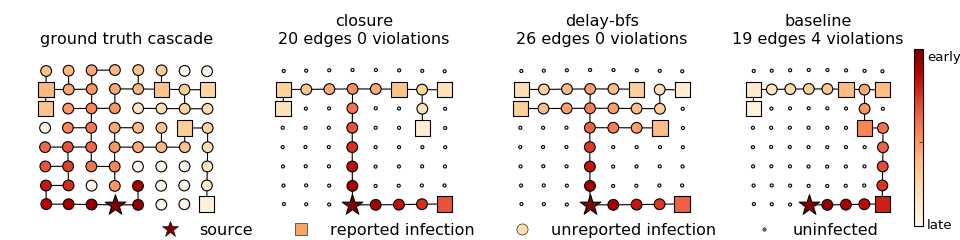

In [31]:
from plot_utils import plot_snapshot, add_colorbar
from utils import extract_edges

with_label = False
max_node_size = 750
fig, ax = plt.subplots(1, 4, figsize=(12, 2.5))
for a in ax:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.axis('off')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
              max_node_size=max_node_size,
              ax=ax[0],
              edges=extract_edges(true_tree))
ax[0].set_title('ground truth cascade')
plot_snapshot(gnx, pos, infer_infection_time_from_tree(closure_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
             ax=ax[1], arrows=True, 
              max_node_size=max_node_size,
             edges=extract_edges(closure_tree))
set_title(ax[1], 'closure', closure_tree)

plot_snapshot(gnx, pos, infer_infection_time_from_tree(tbfs_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
              ax=ax[2], arrows=True,
              max_node_size=max_node_size,
              edges=extract_edges(tbfs_tree))
set_title(ax[2], 'delay-bfs', tbfs_tree)

plot_snapshot(gnx, pos, infer_infection_time_from_tree(st_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
              ax=ax[3], arrows=True,
              max_node_size=max_node_size,
              edges=extract_edges(st_tree_dir))
plt.tight_layout()
set_title(ax[3], 'baseline', st_tree_dir)

import matplotlib as mpl



cmap='OrRd'
eps = np.maximum(0.0000000001, np.min(infection_times)/1000.)
vmin = np.min(infection_times) - eps
vmax = np.max(infection_times)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scm = mpl.cm.ScalarMappable(norm, cmap)
scm.set_array(infection_times)

cbar = plt.colorbar(scm)
tick_locator = mpl.ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_yticklabels(['late', '','early'])



<IPython.core.display.Javascript object>


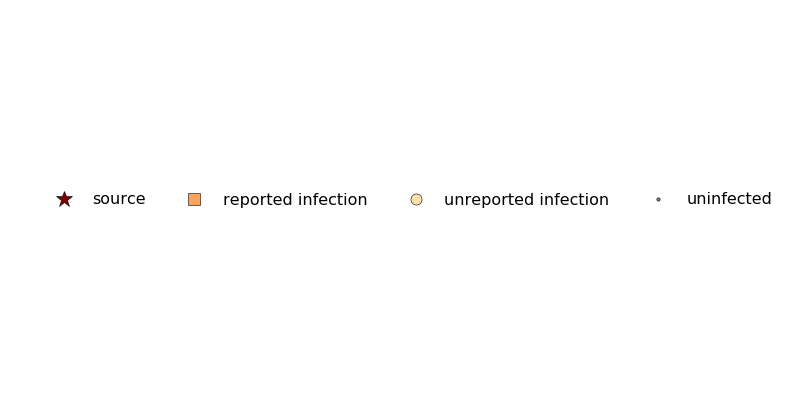

In [87]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

line1 = Line2D(range(1), range(1), color="white", marker='*', markerfacecolor="maroon", markersize=15)
line2 = Line2D(range(1), range(1), color="white", marker='s',markerfacecolor="sandybrown", markersize=10)
line3 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="navajowhite", markersize=10)
line4 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="gray", markersize=3)
ax.legend((line1,line2,line3,line4),('source', 'reported infection', 'unreported infection', 'uninfected'),
         numpoints=1,
         ncol=4, loc='center',
         frameon=False)
fig.show()
fig.savefig(dirname + 'legend.pdf')

In [33]:
fig.savefig('figs/paper_experiment/illustration.pdf')